In [1]:
import io
import re
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report


In [2]:
with open("./ReadyData_PutinG20.csv", 'r', encoding='utf8') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"Each data point looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

﻿text;vaderLabel

Each data point looks like this:

@SNMilitary Welcome Rusia to bali on G20, 🇮🇩  waiting  🇷🇺;Positive



In [3]:
# Loading & Preprocessing Data

def remove_stopwords(sentence):
    # List of stopwords
    stopwords = ["rt", "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    
    # Sentence converted to lowercase-only
    sentence = sentence.lower()

    no_stopwords = sentence.split()
    no_stopwords = [w for w in no_stopwords if w not in stopwords]
    sentence = " ".join(no_stopwords)
    sentence = re.sub('(?<=\s)@[\w]+|(?<=^)@[\w]+', '', sentence)

    alnum = sentence.split()
    alnum = [a for a in alnum if a.isalnum()]
    sentence = " ".join(alnum)
    
    return sentence

def remove_emojis(sentence):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', sentence)

def parse_data_from_file(filename):
    sentences = []
    labels = []
    with open(filename, 'r', encoding='utf8') as csvfile:
        reader = csv.reader(csvfile, delimiter=';')
        next(reader)
        for row in reader:
            labels.append(row[1])
            sentence = row[0]
            sentence = remove_stopwords(sentence)
            sentence = remove_emojis(sentence)
            sentences.append(sentence)

    return sentences, labels

In [4]:
# Test the functions
sentences, labels = parse_data_from_file("./ReadyData_PutinG20.csv")

print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words (after removing stopwords).\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}")

There are 12462 sentences in the dataset.

First sentence has 4 words (after removing stopwords).

There are 12462 labels in the dataset.

The first 5 labels are ['Positive', 'Positive', 'Neutral', 'Negative', 'Negative']


In [5]:
# to remove duplicated from list labels
result = [] 
[result.append(x) for x in labels if x not in result] 

# printing list labels after removal 
print ("The list after removing duplicates: " + str(result)) 

The list after removing duplicates: ['Positive', 'Neutral', 'Negative']


In [6]:
# Defining useful global variables
NUM_WORDS = 500
EMBEDDING_DIM = 16
avg_sentence = sum( map(len, sentences) ) / len(sentences)
MAXLEN = round(avg_sentence)
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

In [7]:
# ## Training & Validation Spli ##

# def train_val_split(sentences, labels, training_split):
    
#     # Compute the number of sentences that will be used for training (should be an integer)
#     train_size = int(len(sentences) * training_split)

#     # Split the sentences and labels into train/validation splits
#     train_sentences = sentences[:train_size]
#     train_labels = labels[:train_size]

#     validation_sentences = sentences[train_size:]
#     validation_labels = labels[train_size:]
    
#     return train_sentences, validation_sentences, train_labels, validation_labels

In [8]:
# # Test your function
# train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

# print(f"There are {len(train_sentences)} sentences for training.\n")
# print(f"There are {len(train_labels)} labels for training.\n")
# print(f"There are {len(val_sentences)} sentences for validation.\n")
# print(f"There are {len(val_labels)} labels for validation.")

There are 9969 sentences for training.

There are 9969 labels for training.

There are 2493 sentences for validation.

There are 2493 labels for validation.


In [9]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(sentences, labels, shuffle=True, stratify=labels,
                                                    test_size=0.3, random_state=100)

# % of training set
len(train_sentences)/len(sentences)
print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

0.699967902423367

In [10]:
## Tokenization - Sequence & Padding ##

def fit_tokenizer(train_sentences, num_words, oov_token):
        
    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words, oov_token=oov_token)
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)    
    
    return tokenizer

In [11]:
# Test your function
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 1064 words

<OOV> token included in vocabulary


In [12]:
word_index

{'<OOV>': 1,
 'putin': 2,
 'g20': 3,
 'vladimir': 4,
 'not': 5,
 'allowed': 6,
 'summit': 7,
 'invited': 8,
 'will': 9,
 'president': 10,
 'invite': 11,
 'indonesia': 12,
 'received': 13,
 'news': 14,
 'russian': 15,
 'approach': 16,
 'considers': 17,
 'condemned': 18,
 'attend': 19,
 'hell': 20,
 'ukraine': 21,
 'war': 22,
 'biden': 23,
 'russia': 24,
 'arrested': 25,
 'immediately': 26,
 'well': 27,
 'views': 28,
 'exchanged': 29,
 'phone': 30,
 'situation': 31,
 'bloomberg': 32,
 'go': 33,
 'indonesian': 34,
 'plans': 35,
 'claims': 36,
 'attends': 37,
 'actually': 38,
 'get': 39,
 'meet': 40,
 'attempt': 41,
 'pushing': 42,
 'continued': 43,
 'towards': 44,
 'wall': 45,
 'volodymyr': 46,
 'zelensky': 47,
 'breaking': 48,
 'moscow': 49,
 'let': 50,
 'widodo': 51,
 'joko': 52,
 'just': 53,
 'world': 54,
 'us': 55,
 'announced': 56,
 'recall': 57,
 'days': 58,
 'probably': 59,
 'nice': 60,
 'giving': 61,
 'still': 62,
 'confirmed': 63,
 'sitting': 64,
 'palace': 65,
 'accepted': 66,
 

In [13]:
#seq_and_pad
def seq_and_pad(sentences, tokenizer, padding, maxlen):
       
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlen)
    
    return padded_sequences

In [14]:
# Test your function
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (8723, 45)

Padded validation sequences have shape: (3739, 45)


In [15]:
print(f"Padded training sequences:\n {train_padded_seq}\n")
print(f"Padded validation sequences:\n {val_padded_seq}")

Padded training sequences:
 [[  2  13  11 ...   0   0   0]
 [  4   2   5 ...   0   0   0]
 [ 17  16   3 ...   0   0   0]
 ...
 [224 225  94 ...   0   0   0]
 [  4   2   5 ...   0   0   0]
 [ 29  28  30 ...   0   0   0]]

Padded validation sequences:
 [[ 2 13 11 ...  0  0  0]
 [12  8 15 ...  0  0  0]
 [20  2  8 ...  0  0  0]
 ...
 [20  2  8 ...  0  0  0]
 [ 2 38 37 ...  0  0  0]
 [64 65 60 ...  0  0  0]]


In [16]:
# tokenize_labels

def tokenize_labels(all_labels, split_labels):
    
    # Instantiate the Tokenizer (no additional arguments needed)
    label_tokenizer = Tokenizer()
    
    # Fit the tokenizer on all the labels
    label_tokenizer.fit_on_texts(all_labels)
    
    # Convert labels to sequences
    label_seq = label_tokenizer.texts_to_sequences(split_labels)
    
    # Convert sequences to a numpy array. Don't forget to substact 1 from every entry in the array!
    label_seq_np = np.array(label_seq) - 1
    
    return label_seq_np

In [17]:
# Test your function
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)

print(f"First 5 labels of the training set should look like this:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set should look like this:\n{val_label_seq[:5]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_label_seq.shape}\n")

First 5 labels of the training set should look like this:
[[1]
 [0]
 [1]
 [0]
 [1]]

First 5 labels of the validation set should look like this:
[[1]
 [0]
 [1]
 [1]
 [0]]

Tokenized labels of the training set have shape: (8723, 1)

Tokenized labels of the validation set have shape: (3739, 1)



In [18]:
print(f"The first 5 train labels are {train_labels[:5]}\n")
print(f"The first 5 validation labels are {val_labels[:5]}\n")

# count number of each label in the data
res = {}

for i in labels:
    res[i] = labels.count(i)
    
print(f"the number of each label in the data:\n {res}")

The first 5 train labels are ['Negative', 'Neutral', 'Negative', 'Neutral', 'Negative']

The first 5 validation labels are ['Negative', 'Neutral', 'Negative', 'Negative', 'Neutral']

the number of each label in the data:
 {'Positive': 1675, 'Neutral': 5866, 'Negative': 4921}


In [19]:
print(train_sentences[10])
print(train_padded_seq[10])

indonesia invited russian putin g20 summit
[12  8 15  2  3  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


## GRU

In [36]:
# GRADED FUNCTION: create_model
def model_GRU(num_words, embedding_dim, maxlen):
    
    tf.random.set_seed(123)
    gru_dim = 32
    dense_dim = 6
    ### START CODE HERE
    
    modelGRU = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
        tf.keras.layers.Dense(dense_dim, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    modelGRU.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adamax(learning_rate=3e-4),
                  metrics=['accuracy']) 

    ### END CODE HERE

    return modelGRU

modelGRU = model_GRU(NUM_WORDS, EMBEDDING_DIM, MAXLEN)
modelGRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 45, 16)            8000      
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
 dense_5 (Dense)             (None, 3)                 21        
                                                                 
Total params: 18,011
Trainable params: 18,011
Non-trainable params: 0
_________________________________________________________________


In [37]:
# # myCallback
# class myCallback(tf.keras.callbacks.Callback):
#         # Define the correct function signature for on_epoch_end
#         def on_epoch_end(self, epoch, logs={}):
#             if logs.get('accuracy') is not None and logs.get('accuracy') > 0.95: # @KEEP
#                 print("\nReached 95% accuracy so cancelling training!") 
                
#                 # Stop training once the above condition is met
#                 self.model.stop_training = True




In [38]:
mc = ModelCheckpoint('classifier-putinG20-BiGRU_04.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# # es = EarlyStopping(restore_best_weights=True, monitor='val_loss', mode='min', verbose=1, patience=2)
# callbacks = myCallback()

In [39]:
historyGRU = modelGRU.fit(train_padded_seq, 
                        train_label_seq, 
                        epochs=50,
                        callbacks = [mc],
                        # callbacks = [mc, callbacks],  
                        validation_data=(val_padded_seq, val_label_seq))

Epoch 1/50
271/273 [============================>.] - ETA: 0s - loss: 0.9913 - accuracy: 0.4688
Epoch 1: val_accuracy improved from -inf to 0.47071, saving model to classifier-putinG20-BiGRU_04.h5
273/273 [==============================] - 6s 13ms/step - loss: 0.9903 - accuracy: 0.4692 - val_loss: 0.9079 - val_accuracy: 0.4707
Epoch 2/50
271/273 [============================>.] - ETA: 0s - loss: 0.8131 - accuracy: 0.4724
Epoch 2: val_accuracy improved from 0.47071 to 0.58813, saving model to classifier-putinG20-BiGRU_04.h5
273/273 [==============================] - 3s 11ms/step - loss: 0.8126 - accuracy: 0.4729 - val_loss: 0.6812 - val_accuracy: 0.5881
Epoch 3/50
270/273 [============================>.] - ETA: 0s - loss: 0.5756 - accuracy: 0.7980
Epoch 3: val_accuracy improved from 0.58813 to 0.82696, saving model to classifier-putinG20-BiGRU_04.h5
273/273 [==============================] - 3s 12ms/step - loss: 0.5745 - accuracy: 0.7980 - val_loss: 0.4735 - val_accuracy: 0.8270
Epoch 4

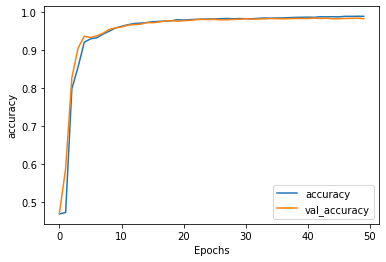

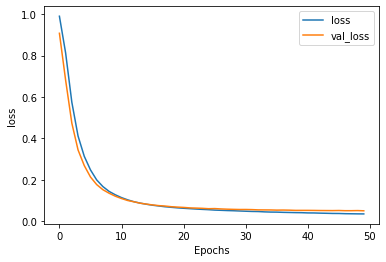

In [40]:
def plot_graphs(historyGRU, metric):
    plt.plot(historyGRU.history[metric])
    plt.plot(historyGRU.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(historyGRU, "accuracy")
plot_graphs(historyGRU, "loss")

In [41]:
predictions = modelGRU.predict(train_padded_seq)

print(train_sentences[1])
print(train_labels[1])
print(train_label_seq[1])

print(predictions[1])

vladimir putin not allowed g20
Neutral
[0]
[9.9826592e-01 1.0757669e-03 6.5826665e-04]


117/117 [==============================] - 1s 6ms/step - loss: 0.0501 - accuracy: 0.9821
[[1740   11    9]
 [  12 1452   12]
 [   7   16  480]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1760
           1       0.98      0.98      0.98      1476
           2       0.96      0.95      0.96       503

    accuracy                           0.98      3739
   macro avg       0.98      0.98      0.98      3739
weighted avg       0.98      0.98      0.98      3739

0.9820807576179504
Accuracy is: 0.9820807702594276


<AxesSubplot:>

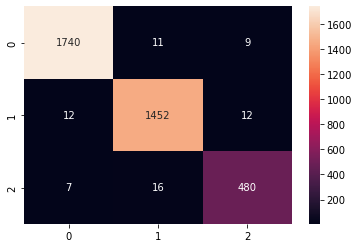

In [42]:
scores = []
score = modelGRU.evaluate(val_padded_seq, val_label_seq, verbose = 1)

akurasi = score[1]
scores.append(akurasi)
y_pred = modelGRU.predict(val_padded_seq)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(val_label_seq, y_pred)

print(cm)
print(classification_report(val_label_seq,y_pred))

def Average(lst):
 return sum(lst) / len(lst)

print(Average(scores))
ac= accuracy_score(val_label_seq, y_pred)
print('Accuracy is:', ac)
sns.heatmap(cm,annot=True,fmt='d')


## Load Model for Summary ##

In [20]:
new_model = tf.keras.models.load_model('./classifier-putinG20-BiGRU_01-callback.h5')

# Check its architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 45, 16)            8000      
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
 dense_3 (Dense)             (None, 3)                 21        
                                                                 
Total params: 18,011
Trainable params: 18,011
Non-trainable params: 0
_________________________________________________________________


In [21]:
scores = []
score = new_model.evaluate(val_padded_seq, val_label_seq, verbose = 1)

akurasi = score[1]
scores.append(akurasi)
y_pred = new_model.predict(val_padded_seq)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(val_label_seq, y_pred)

print(cm)
print(classification_report(val_label_seq,y_pred))

def Average(lst):
 return sum(lst) / len(lst)

print(Average(scores))


117/117 [==============================] - 2s 5ms/step - loss: 0.1209 - accuracy: 0.9559
[[1713   20   27]
 [  23 1421   32]
 [  32   31  440]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1760
           1       0.97      0.96      0.96      1476
           2       0.88      0.87      0.88       503

    accuracy                           0.96      3739
   macro avg       0.94      0.94      0.94      3739
weighted avg       0.96      0.96      0.96      3739

0.9558705687522888


In [22]:
# %pip install pydot
# %pip install pydotplus
# %pip install graphviz

In [23]:
tf.keras.utils.plot_model(new_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
